# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [1]:
import torch
from torchvision import datasets, transforms

In [17]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [8]:
x = datasets.MNIST('data', download=True)
x[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [10]:
x[0][0]

In [21]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [23]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [25]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

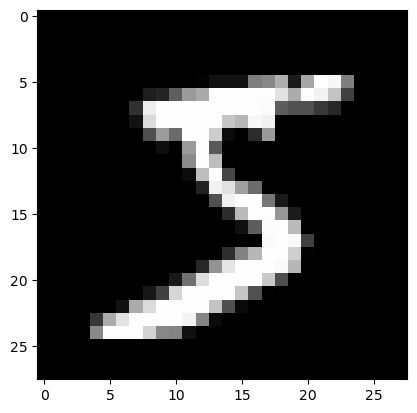

In [26]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

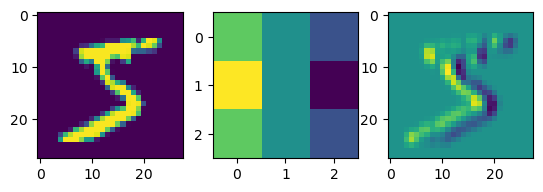

In [29]:
kernel = np.array([[1, 0, -1], 
                   [2, 0, -2], 
                   [1, 0, -1]]) #edge detection filter -these are just image arrays
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)




# Create Network

In [30]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [31]:
class Net(nn.Module): 
    def __init__(self): #this first definition is what is defining the layers 
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x): #how do you connect all of the layers together 
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [32]:
network = Net() 
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_70609/495873996.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [33]:
def visualize(): #define the function 
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

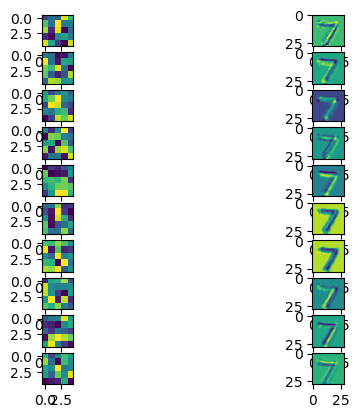

In [34]:
visualize()#we are training on test not our image- thats why this one is a 7- this filter is initialization, no patteren, just random , just pulling uit the first 5 values 

# Predict Using Network

In [35]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [36]:
y = network(x[0]) #y is the prediction and x is the actual data
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_70609/495873996.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([8, 8, 6, 6, 6])

# First Test and Train

In [37]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [38]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_70609/495873996.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 10%



In [39]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [40]:
train()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_70609/495873996.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.312267
Train loss: 1.880871
Train loss: 1.133040
Train loss: 1.078617
Train loss: 0.645405
Train loss: 0.684108
Train loss: 0.648001
Train loss: 0.562433
Train loss: 0.509188
Train loss: 0.436438


# Train Network

In [41]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_70609/495873996.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.322048
Train loss: 1.983512
Train loss: 1.050618
Train loss: 0.974963
Train loss: 0.778917
Train loss: 0.703693
Train loss: 0.506485
Train loss: 0.666431
Train loss: 0.519969
Train loss: 0.487269
Test accuracy: 94%

Train loss: 0.447027
Train loss: 0.323872
Train loss: 0.381899
Train loss: 0.611156
Train loss: 0.597887
Train loss: 0.451708
Train loss: 0.271607
Train loss: 0.547562
Train loss: 0.621212
Train loss: 0.373321
Test accuracy: 96%

Train loss: 0.178174
Train loss: 0.300121
Train loss: 0.288222
Train loss: 0.546716
Train loss: 0.285536
Train loss: 0.363021
Train loss: 0.286252
Train loss: 0.344522
Train loss: 0.346905
Train loss: 0.277702
Test accuracy: 97%

Train loss: 0.321110
Train loss: 0.136194
Train loss: 0.289465
Train loss: 0.471193
Train loss: 0.197785
Train loss: 0.221135
Train loss: 0.150015
Train loss: 0.378034
Train loss: 0.425081
Train loss: 0.386323
Test accuracy: 97%

Train loss: 0.179091
Train loss: 0.112329
Train loss: 0.203582
Train loss: 0.208

# Inspect Network

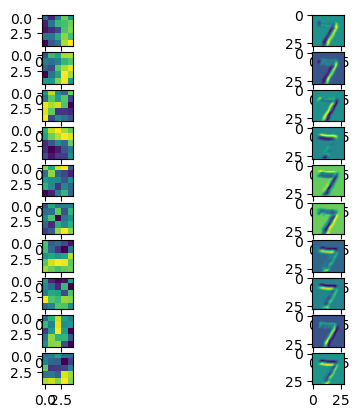

In [42]:
visualize()

In [43]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [44]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_70609/495873996.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

In [61]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600)) #this is the number we replace and we re-run the code above- to see how much data do you really need to be accurate
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [64]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_70609/495873996.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.282178
Test accuracy: 9%

Train loss: 2.293426
Test accuracy: 15%

Train loss: 2.285576
Test accuracy: 37%

Train loss: 2.251769
Test accuracy: 53%

Train loss: 2.236660
Test accuracy: 57%



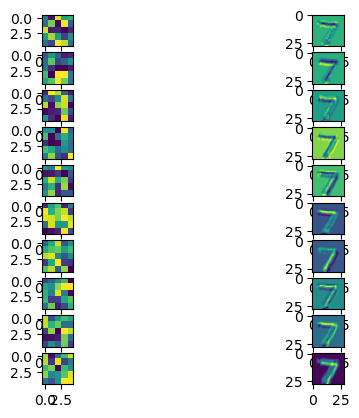

In [65]:
visualize()

In [ ]:
Exercises
1. PyTorch – How much data is needed?
1a. What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?

60,000- test accuracy 98%
30,000- test accuracy 97%
6,000- test accuracy 92%
3,000- test accuracy 84%
600- test accuracy 32%

1b. How do the weights looks different when trained with 60,000 vs 600?
In the 60000 condition, the visuals are more clustered, the 600 seems to be scattered around a bit more. 

In [2]:
import os
print(os.getcwd()) 

/Users/cmdb/qbb2024/pytorch
